In [6]:
import pandas as pd
import os,jieba
#用word2vec做词向量
data=pd.read_excel("data/数据.xlsx")
data.head()

,Unnamed: 0,评论,情感
0,0,"首先感觉不像大酒店,应该属于公寓式酒店,房间很小,明显是住宅公寓改装的.\n\n其次门童的服...",0
1,1,服务很好。24小时供餐。我们晚上10点到酒店，专门为我们提供晚餐，很是感动，且价格也比较实惠...,1
2,2,标准间环境不怎么的，楼层低、有蚊子。商务间还可以，大床房1\n\n\n\n,1
3,3,"首先感觉不像大酒店,应该属于公寓式酒店,房间很小,明显是住宅公寓改装的.\n\n其次门童的服...",0
4,4,酒店的基本设施一般，但服务态度确实很不错，房间8楼以下就是新装修的，8楼的房间就比较成旧，洗...,1


In [3]:
values=data["评论"].values
values[:2]

array(['首先感觉不像大酒店,应该属于公寓式酒店,房间很小,明显是住宅公寓改装的.\n\n其次门童的服务不好,傻站在那里,我进去朝我傻傻的看着,既不问好,也不微笑,还不如放个像机场一样的假人算了,第一印象差.当然前台的服务也很一般,说是从什么日记本,但不是我主动打电话讨要的话根本没人送来.\n\n如果说300多块的房价我就不说什么了,但600的房价确实让我感觉太不值了.\n\n补充点评 2008年1月16日 ： 补充一点:附件的交通也不方便,说道这里我要批评携程,描述这个酒店在八佰伴附近,去查查词典看看什么叫"附近"\n\n宾馆反馈 2008年1月18日 ： 感谢您对酒店提出的善意的批评。酒店对相关部门的经理及员工进行了批评与处理，并从工作流程上进行了重新调整，尽量杜绝漏发礼品情况的发生。真心地希望客人能再次入住，对酒店的服务进行监督，以便酒店的服务能更趋完善。\n\n\n\n\n\n\n\n',
       '服务很好。24小时供餐。我们晚上10点到酒店，专门为我们提供晚餐，很是感动，且价格也比较实惠。唯一感到不足的是，1号楼与2号楼的入住手续是分别办的，我们先开车找到酒店大堂，被告知这是2号楼，要到1号楼办手续。但携程订房时并未告知是几号楼。\n\n\n\n'],
      dtype=object)

In [7]:
stopwords_file = "data/stopwords.txt"#引入停用词
with open(os.path.join(stopwords_file), "r", encoding="utf8") as f:
    stopwords_list = [word.strip() for word in f.read()]
seg_res_list = [ jieba.lcut(item) for item in values ]
seg_res_clean = []
for seg in seg_res_list:
    for word in seg:
        if word not in  stopwords_list:
            seg_res_clean.append(word)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/b6/sj0f93ps3rn4fdfsd4mkgj_00000gn/T/jieba.cache
Loading model cost 1.450 seconds.
Prefix dict has been built successfully.


In [8]:
#转换词向量
from gensim.models import word2vec
model2=word2vec.Word2Vec(seg_res_list, 
                 vector_size=50, # 词向量的维度
                 workers=4)  # 调用的进程数，CPU
# 常用Word2Vec的参数：min_count,如果词频小于 min_count, word2vec 不会把这个词放入 vocab 里

# 保存模型
model2.save('imdb.d2v')

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
# 加载模型
model2 = word2vec.Word2Vec.load('imdb.d2v')
model2.wv["酒店"]

array([-2.0509264 ,  0.11170452, -2.5636885 , -1.2895819 ,  1.2490431 ,
        2.397096  , -1.2134436 , -2.0670412 ,  1.8427081 ,  1.7948996 ,
       -0.5657646 , -0.41461805,  0.38635805,  0.25829428, -1.5755949 ,
        1.0280821 , -2.008307  ,  1.0605855 , -0.7483092 ,  1.6842508 ,
       -2.539072  ,  0.548048  , -1.5911107 , -4.2691464 ,  1.5343863 ,
       -1.1384578 ,  2.7300422 , -1.6171165 ,  0.24449292,  3.395441  ,
        0.93074846, -1.326947  , -3.9720182 ,  2.0117798 , -0.18932387,
       -1.5853899 , -1.4421536 , -1.7334889 , -2.484131  , -1.5386659 ,
       -0.13260813,  0.67946583,  0.11642793, -0.40713215, -1.7486618 ,
        0.7912926 ,  1.7350955 , -3.1414418 , -4.505804  ,  0.48940024],
      dtype=float32)

In [11]:
from sklearn.model_selection import train_test_split
X = data['评论'].values
y = data['情感'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
# 用 word vec 的均值作为 doc vec
def get_doc_vec(sentence, model):
    scores = np.array([model2.wv[word] for word in jieba.lcut(sentence) if word in model.wv])
    return np.mean(scores, axis=0)

In [13]:
import numpy as np
X_word2vec_train = np.array([get_doc_vec(sentence, model2) for sentence in X_train])
X_word2vec_test =  np.array([get_doc_vec(sentence, model2) for sentence in X_test])

In [14]:
#使用logit分类
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_word2vec_train,y_train)

LogisticRegression()

In [15]:
y_test_pred = lr.predict(X_word2vec_test)

In [16]:
acc = lr.score(X_word2vec_test,y_test)
acc

0.99875

In [46]:
# 词典
words = model2.wv.index_to_key
words_list=[]
for word in words:
    if word not in stopwords_list:
        words_list.append(word)
        
print(words_list[:10])  

['\n', '酒店', ' ', '服务', '什么', '进行', '批评', '感觉', '月', '很']


In [48]:
# 获取对应词向量
vectors = model2.wv[words_list]
print(vectors.shape)

(2108, 50)


In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [50]:
word_2d = pca.fit_transform(vectors)
print(word_2d.shape)

(2108, 2)


In [51]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
plt.rcParams['axes.unicode_minus']=False #负值显示

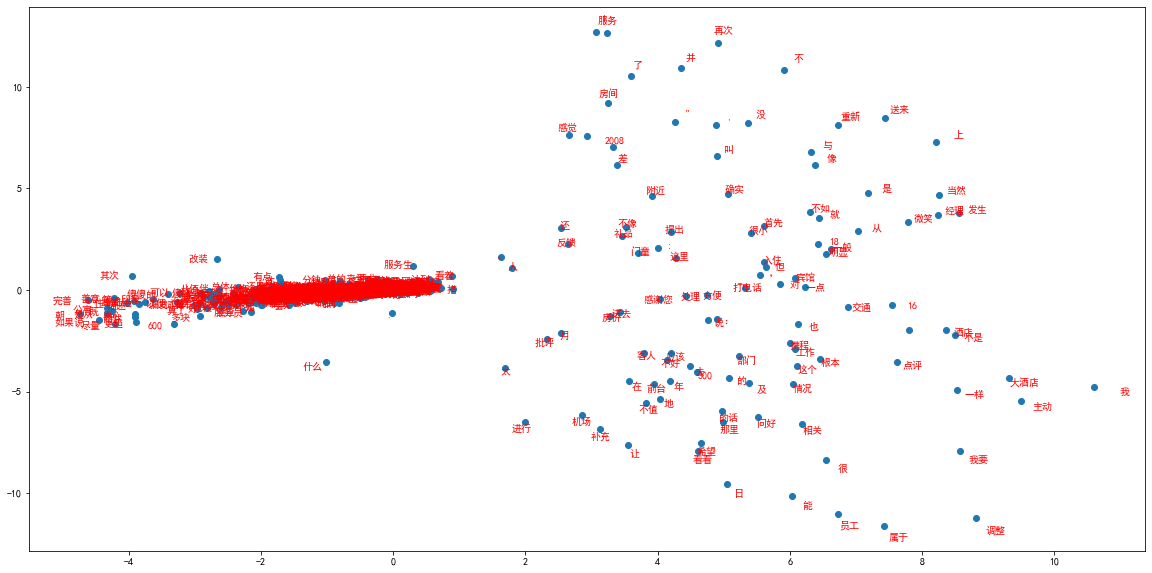

In [53]:
plt.figure(figsize=(20,10))
plt.scatter(word_2d[:,0],word_2d[:,1])
for i in range(len(word_2d)):
    plt.text(word_2d[i,0]*1.05, word_2d[i,1]*1.05, words[i], fontsize=10, color = "r",  weight = "light", verticalalignment='center', horizontalalignment='right',rotation=0) #给散点加标签
plt.savefig('word_plot.png', dpi=300, bbox_inches='tight')

In [67]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 100#所有评价评的最大单词数量
sequence_length = 50#装换为向量的最大维度
embedding_dimension = 100#

# 生成数据

X_word2vec_train=X_word2vec_train+10
X_word2vec_test=X_word2vec_test+10
print(X_word2vec_train.shape)
print(X_word2vec_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 50)
(800, 50)
(3200,)
(800,)


In [81]:

# 构造分类器
filter_sizes = [2,3, 4, 5]#卷积核的大小
def convolution():
    # 定义输入层，制定输入数据的形状
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=20,                                # 卷积层神经元（卷积核）数目
                             kernel_size=(size, embedding_dimension),   # 卷积核大小
                             strides=1,                                 # 设置步长
                             padding='valid',                           # padding策略（vaild 或 same,same保持原有的卷积层的维度，边缘补充0） 
                             activation='relu')(inn)                    # 激活函数
        
        pool = layers.MaxPool2D(pool_size=(sequence_length - size + 1, 1), 
                                           padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)

    model = keras.Model(inputs=inn, outputs=outt)
    return model


def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=embedding_dimension,
                         input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')

    ])
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model


model = cnn_mulfilter()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           10000     
_________________________________________________________________
reshape_6 (Reshape)          (None, 50, 100, 1)        0         
_________________________________________________________________
model_6 (Functional)         (None, 1, 1, 80)          28080     
_________________________________________________________________
flatten_6 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                810       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

Epoch 1/5
45/45 [==============================] - 4s 66ms/step - loss: 0.5742 - accuracy: 0.7233 - val_loss: 0.3658 - val_accuracy: 0.9375
Epoch 2/5
45/45 [==============================] - 3s 62ms/step - loss: 0.1995 - accuracy: 0.9559 - val_loss: 0.0426 - val_accuracy: 1.0000
Epoch 3/5
45/45 [==============================] - 3s 62ms/step - loss: 0.0882 - accuracy: 0.9913 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 4/5
45/45 [==============================] - 3s 68ms/step - loss: 0.0767 - accuracy: 0.9965 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 5/5
45/45 [==============================] - 3s 63ms/step - loss: 0.0697 - accuracy: 0.9972 - val_loss: 0.0061 - val_accuracy: 1.0000


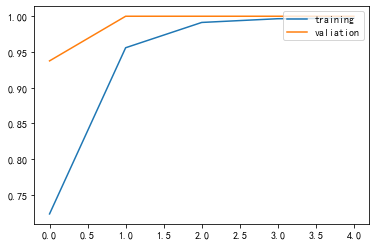

In [82]:
#训练模型
history = model.fit(X_word2vec_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

In [95]:
result = model.evaluate(X_word2vec_test, y_test)
print("loss=%s,accuracy=%s" %(result[0],result[1]))


25/25 [==============================] - 0s 8ms/step - loss: 0.0060 - accuracy: 1.0000
loss=0.006011746358126402,accuracy=1.0


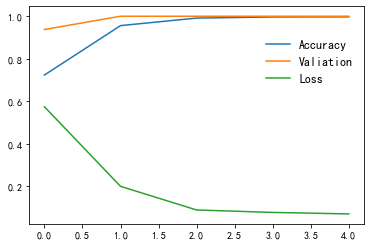

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.legend(['Accuracy', 'Valiation',"Loss"], loc='upper right',bbox_to_anchor=(1, 0.9),frameon=False,fontsize=12)
plt.savefig('cnn_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [101]:
#朴素贝叶斯分类
from sklearn.naive_bayes import MultinomialNB     
from sklearn.metrics import classification_report

#使用朴素贝叶斯进行训练
mnb = MultinomialNB()   # 使用默认配置初始化朴素贝叶斯
mnb.fit(X_word2vec_train,y_train)   

MultinomialNB()

In [102]:
score=mnb.score(X_word2vec_test,y_test)

In [104]:
score

0.99875

In [111]:
#支持向量机
#Import Library
from sklearn import svm
model = svm.SVC(kernel='linear', gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(X_word2vec_train, y_train)
score=model.score(X_word2vec_test, y_test)
#Predict Output
#predicted= model.predict(x_test)

In [112]:
score

1.0

In [113]:
data= pd.DataFrame({'分类准确率':[0.99875, 0.99875, 0.9,0.996],
                      '分类方法':["logi分类","贝叶斯分类","支持向量机","CNN"],
                      })
data

,分类准确率,分类方法
0,0.99875,logi分类
1,0.99875,贝叶斯分类
2,0.90000,支持向量机
3,0.99600,CNN


<ipython-input-154-a17cdf907abd>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ticklabels, fontsize=17,rotation=45)
<ipython-input-154-a17cdf907abd>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=17)


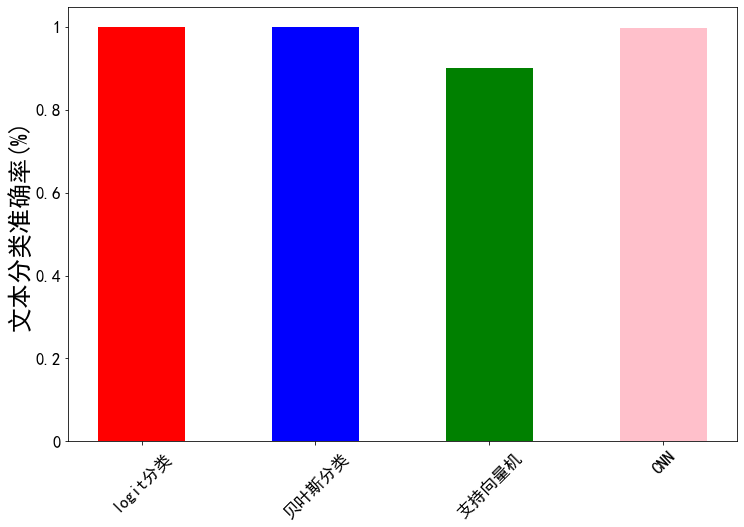

In [154]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #图中文字体设置为黑体
plt.rcParams['axes.unicode_minus']=False #负值显示
fig,ax1 = plt.subplots(figsize=(12,8))
labels =  ["logi分类","贝叶斯分类","支持向量机","CNN"]
ticklabels =["logit分类","贝叶斯分类","支持向量机","CNN"]
ax1.bar(data["分类方法"],data["分类准确率"],color=["red","blue","green","pink"],width=0.5)
#ax1.set_xlabel('文本分类方法',fontsize=25)
ax1.set_ylabel("文本分类准确率(%)",fontsize=25)
ax1.set_xticklabels(ticklabels, fontsize=17,rotation=45)
ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=17)
plt.savefig('准确率.png', dpi=300, bbox_inches='tight')
#ax1.legend(labels=labels,loc='upper right', fontsize=8,bbox_to_anchor=(1, 0.9))#调整图例的位置